读取和绘制音频数据
- 理解音频信号的基本结构。音频文件是实际音频信号的数字化形式，实际音频信号是复杂的连续波形
- 为保存成数字化形式，需要对音频信号进行采样，并转化成数字。如语音通常以44100 Hz的频率进行采样，意味着每秒钟信号被分解成44100份，然后这些抽样值被保存。每1/44100 s都会存储一次值。如果采样频率很高，在实际播放音频时，会感觉到信号是连续值。


Shape: (132300,)
Datatype: int16
Duration: 3.0 seconds


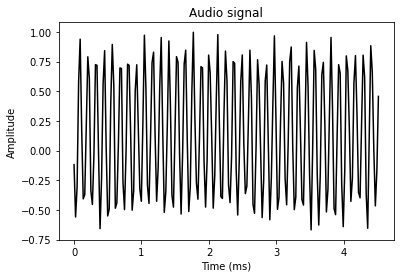

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Read the input file
sampling_freq, audio = wavfile.read('input_read.wav')

# Print the params
print('\nShape:', audio.shape)
print('Datatype:', audio.dtype)
print('Duration:', round(audio.shape[0] / float(sampling_freq), 3), 'seconds')

# Normalize the values
audio = audio / (2.**15)

# Extract first values range for plotting
audio = audio[:200]

# Build the time axis
x_values = np.arange(0, len(audio), 1) / float(sampling_freq)

# Convert to seconds
x_values *= 1000

# Plotting the chopped audio signal
plt.plot(x_values, audio, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio signal')
plt.show()

将音频信号转化为频域 - 傅里叶变换(Fourier Transforms)
- 音频信号是不同频率、幅度和相位的正弦波的复杂混合。正弦波也叫正弦曲线。音频信号的频率内容隐藏了很多信息，一个音频信号的性质由其频率内容决定。
- 傅里叶变换(Fourier Transforms)，将音频信号转化为频域
- https://www.thefouriertransform.com/

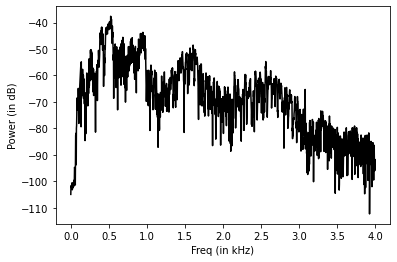

In [16]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Read the input file
# 读取音频文件
sampling_freq, audio = wavfile.read('input_freq.wav')

# Normalize the values
# 对信号进行标准化
audio = audio / (2.**15)

# Extract length
# 音频信号是一个NumPy数组，提取其长度
len_audio = len(audio)

# Apply Fourier transform
# 应用傅里叶变换 - 傅里叶变换是关于中心点对称的,
# 因此只需要转换信号的前半部分.最终目标是提取功率信号,先将信号值平方
transformed_signal = np.fft.fft(audio)
half_length = np.ceil((len_audio + 1) / 2.0)
transformed_signal = abs(transformed_signal[0:int(half_length)])
transformed_signal /= float(len_audio)
transformed_signal **= 2

# Extract length of transformed signal
# 提取信号长度
len_ts = len(transformed_signal)

# Take care of even/odd cases
# 将部分信号乘以2
if len_audio % 2:
    transformed_signal[1:len_ts] *= 2
else:
    transformed_signal[1:len_ts-1] *= 2

# Extract power in dB, 获取功率信号
power = 10 * np.log10(transformed_signal)

# Build the time axis, 建立时间轴
x_values = np.arange(0, half_length, 1) * (sampling_freq / len_audio) / 1000.0

# Plot the figure,绘制信号
plt.figure()
plt.plot(x_values, power, color='black')
plt.xlabel('Freq (in kHz)')
plt.ylabel('Power (in dB)')
plt.show()

用NumPy自定义参数生成音频信号
- 音频信号是一些正弦波的复杂混合,用该原理生成自己的音频信号

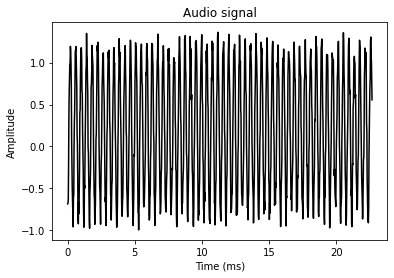

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

# File where the output will be saved, 定义存储生成的音频
output_file = 'output_generated.wav'

# Specify audio parameters, 指定音频生成的参数.
# 希望生成一个3 s长度的信号，采样频率为44100 Hz，音频的频率为587 Hz。
# 时间轴上的值将从（-2pi，2pi）
duration = 3  # seconds
sampling_freq = 44100  # Hz
tone_freq = 587
min_val = -2 * np.pi
max_val = 2 * np.pi

# Generate audio
# 生成音频信号和时间轴。音频信号是一个简单的正弦函数，其相关参数之前已做定义
t = np.linspace(min_val, max_val, duration * sampling_freq)
audio = np.sin(2 * np.pi * tone_freq * t)

# Add some noise，为信号增加一些噪音
noise = 0.4 * np.random.rand(duration * sampling_freq)
audio += noise

# Scale it to 16-bit integer values，将其转换为16位整型数，并将其保存
scaling_factor = pow(2,15) - 1
audio_normalized = audio / np.max(np.abs(audio))
audio_scaled = np.int16(audio_normalized * scaling_factor)

# Write to output file，写入输出文件
write(output_file, sampling_freq, audio_scaled)

# Extract first 100 values for plotting
audio = audio[:1000]

# Build the time axis
x_values = np.arange(0, len(audio), 1) / float(sampling_freq)

# Convert to seconds
x_values *= 1000

# Plotting the chopped audio signal
plt.plot(x_values, audio, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio signal')
plt.show()

合成音乐
- 用合成音频的原理可以合成各种音阶及对应的频率，进而合成一些音乐
- https://pages.mtu.edu/~suits/notefreqs.html

In [37]:
import json
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

# Synthesize tone 定义合成音调函数
def synthesizer(freq, duration, amp=1.0, sampling_freq=44100):
    # Build the time axis，创建时间轴
    t = np.linspace(0, duration, int(duration * sampling_freq))

    # Construct the audio signal，构建音频信号
    audio = amp * np.sin(2 * np.pi * freq * t)

    return audio.astype(np.int16) 


if __name__=='__main__':
    # Input file containing note to frequency mapping
    # 文件包含了音阶及它们的频率
    tone_map_file = 'tone_freq_map.json'
    
    # Read the frequency map
    # 读取频率映射文件
    with open(tone_map_file, 'r') as f:
        tone_freq_map = json.loads(f.read())
        
    # Set input parameters to generate 'G' tone，2秒的G调
    input_tone = 'G'
    duration = 2     # seconds
    amplitude = 10000
    sampling_freq = 44100    # Hz

    # Generate the tone，生成音阶
    synthesized_tone = synthesizer(tone_freq_map[input_tone], duration, amplitude, sampling_freq)

    # Write to the output file
    write('output_tone.wav', sampling_freq, synthesized_tone)

    # Tone-duration sequence，写入输出文件。生成一系列的音阶，让其有音乐的感觉。定义音阶及其持续时间的序列
    tone_seq = [('D', 0.3), ('G', 0.6), ('C', 0.5), ('A', 0.3), ('Asharp', 0.7)]

    # Construct the audio signal based on the chord sequence
    # 构建基于和弦序列的音频信号，迭代该序列并为它们调用合成器函数
    output = np.array([])
    for item in tone_seq:
        input_tone = item[0]
        duration = item[1]
        synthesized_tone = synthesizer(tone_freq_map[input_tone], duration, amplitude, sampling_freq)
        output = np.append(output, synthesized_tone, axis=0)

    # Write to the output file
    # 写入输出文件
    write('output_tone_seq.wav', sampling_freq, output)


提取频域特征
- 信号转化为频域之后，还要将其转化为图形。可使用梅尔频率倒谱系数(MFCC - Mel Frequency Cepstrum Coefficient)
- MFCC首先计算信号的功率谱，然后用滤波器组和离散余弦变换的组合来提取特征
- http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs
- 安装python_speech_features
    - https://python-speech-features.readthedocs.io/en/latest/


MFCC:
Number of windows = 40
Length of each feature = 13

Filter bank:
Number of windows = 40
Length of each feature = 26


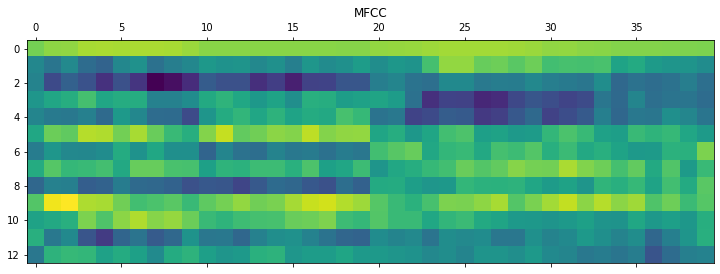

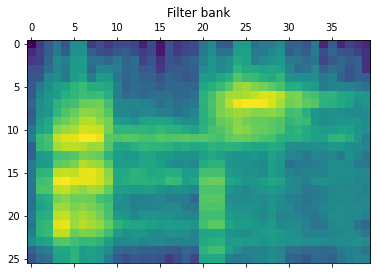

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile 
from python_speech_features import mfcc, logfbank

# Read input sound file
sampling_freq, audio = wavfile.read("input_freq.wav")

# Extract MFCC and Filter bank features - 提取MFCC和过滤器组特征
mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)

# Print parameters - 打印参数，查看可生成多少个窗体
print('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print('Length of each feature =', mfcc_features.shape[1])
print('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print('Length of each feature =', filterbank_features.shape[1])

# Plot the features - 画出特征图，将MFCC特征可视化。转换矩阵，使得时域是水平的
mfcc_features = mfcc_features.T
plt.matshow(mfcc_features)
plt.title('MFCC')

# 将滤波器组特征可视化。需要转换矩阵，使得时域是水平的
filterbank_features = filterbank_features.T
plt.matshow(filterbank_features)
plt.title('Filter bank')

plt.show()

创建隐马尔可夫模型
- 一个语音识别场景，用隐马尔可夫模型（HMMs - Hidden Markov Models）来实现
- 一个音频信号同时也是一个时间序列信号，因此HMMs也同样适用于音频信号的处理
- 假定输出是通过隐藏状态生成的，我们的目标是找到这些隐藏状态，以便对信号建模
- 用到hmmlearn库。http://hmmlearn.readthedocs.org/en/latest

创建一个语音识别器
- 用到的数据文件来源：https://code.google.com/archive/p/hmm-speech-recognition/downloads
- 数据集说明：
    - 包含7个不同的单词，每个单词都有15个音频文件相关
    - 较小的数据集，但是足够理解如何创建一个语音识别器，并识别7个不同的单词
- 需要为每一个类构建一个隐马尔可夫模型。想识别新的输入文件中的单词，需要对该文件运行所有的模型，并找出最佳分数的结果

In [46]:
import os
import argparse 

import numpy as np
from scipy.io import wavfile 
from hmmlearn import hmm
from python_speech_features import mfcc

# Function to parse input arguments
# 解析输入参数的函数
def build_arg_parser():
    parser = argparse.ArgumentParser(description='Trains the HMM classifier')
    parser.add_argument("--input-folder", dest="input_folder", required=True,
            help="Input folder containing the audio files in subfolders")
    return parser

# Class to handle all HMM related processing
# 定义一个类来创建马尔可夫模型
class HMMTrainer(object):
    
    # 初始化这个类。用到高斯隐马尔可夫模型（Gaussian HMMs）来对数据建模，理解这些参数的含义。
    # n_components - 定义隐藏状态的个数
    # cov_type - 定义转移矩阵的协方差类型
    # n_iter - 定义了训练的迭代次数
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        
        # 初始化变量
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        
        # 用以下参数定义模型
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components, 
                    covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    
    # 输入数据是一个NumPy数组，数组的每个元素都是一个特征向量，每个特征向量都包含k个维度
    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data - 基于该模型定义一个提取分数的方法
    def get_score(self, input_data):
        return self.model.score(input_data)

if __name__=='__main__':
    # 解析输入参数
    args = build_arg_parser().parse_args()
    input_folder = args.input_folder
    
    # 初始化隐马尔可夫模型变量
    hmm_models = []

    # Parse the input directory - 解析输入路径
    for dirname in os.listdir(input_folder):
        # Get the name of the subfolder - 获取子文件夹名字
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder): 
            continue

        # Extract the label - 子文件夹名称为该类标记，提取标记
        label = subfolder[subfolder.rfind('/') + 1:]

        # Initialize variables - 初始化用于训练的变量
        X = np.array([])
        y_words = []

        # Iterate through the audio files (leaving 1 file for testing in each class)
        # 迭代所有的音频文件（leave one out - 分别保留一个进行测试）
        for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
            # Read the input file - 读取音频文件
            filepath = os.path.join(subfolder, filename)
            sampling_freq, audio = wavfile.read(filepath)
            
            # Extract MFCC features - 提取MFCC特征
            mfcc_features = mfcc(audio, sampling_freq)

            # Append to the variable X - 将MFCC特征添加到X变量
            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)
            
            # Append the label - 添加标记
            y_words.append(label)

        print('X.shape =', X.shape)
        
        # Train and save HMM model
        # 一旦提取完当前类所有文件的特征，就可以训练并保存隐马尔可夫模型了
        # 隐马尔可夫模型是一个无监督学习的生成模型，所以不需要利用标记针对每一类构建隐马尔可夫模型
        # 假定每个类都将构建一个隐马尔可夫模型，训练并保存
        hmm_trainer = HMMTrainer()
        hmm_trainer.train(X)
        hmm_models.append((hmm_trainer, label))
        hmm_trainer = None

    # Test files
    # 获取一个未被用于训练的测试文件列表
    input_files = [
            'data/pineapple/pineapple15.wav',
            'data/orange/orange15.wav',
            'data/apple/apple15.wav',
            'data/kiwi/kiwi15.wav'
            ]

    # Classify input data - 为输入数据分类
    for input_file in input_files:
        
        # Read input file - 读取每个音频文件
        sampling_freq, audio = wavfile.read(input_file)

        # Extract MFCC features - 提取MFCC特征
        mfcc_features = mfcc(audio, sampling_freq)

        # Define variables - 定义两个变量，分别用于存放最大分数值和输出标记
        max_score = None
        output_label = None

        # Iterate through all HMM models and pick 
        # the one with the highest score
        # 迭代所有HMM模型，通过每个模型运行输入文件，选取得分最高的模型
        for item in hmm_models:
            hmm_model, label = item
            
            # 提取分数，保存最大分数值
            score = hmm_model.get_score(mfcc_features)
            if score > max_score:
                max_score = score
                output_label = label

        # Print the output - 打印真实、预测的标记
        print("\nTrue:", input_file[input_file.find('/')+1:input_file.rfind('/')])
        print("Predicted:", output_label)


usage: ipykernel_launcher.py [-h] --input-folder INPUT_FOLDER
ipykernel_launcher.py: error: the following arguments are required: --input-folder


SystemExit: 2

C:\Users\Tony\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
